This is the first in a series of posts on extracting word representations using statistical language modeling techniques. This first installment includes rudimentary corpus preprocessing, tokenization, vectorization, and inferences within the vector space model. The corpus is a public domain dataset of a million news headlines from the Australian Broadcasting Corporation between 2003 and 2021.

All code blocks for this part of the project are included in this document. The first block includes the imports used in this part of the project.

https://github.com/Using-Namespace-System/Syntagmatic-And-Paradigmatic-Word-Associations.git

The Whole series can be cloned from the link above into a dev container and the configs will include the necessary dependencies.

In [1]:
from itertools import zip_longest
from matplotlib.pyplot import figure
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from scipy.sparse import csr_array
from scipy.sparse import find
from pickleshare import PickleShareDB

df = pd.read_csv('../input/abcnews-date-text.csv')
#nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

Preprocessing the corpus is simplified to filtering out short headlines, small words, and stop-words. Each action is completed in pandas, I believe this may improve readability. The documents are exploded into a single series representing the whole corpus. From here stop-words can be filtered out. No further sanitation is performed.  

In [2]:
#tokenize and sanitize

#tokenize documents into individual words
df['tokenized'] = df.headline_text.str.split(' ')

#remove short documents from corpus
df['length'] = df.tokenized.map(len)
df = df.loc[df.length > 1]

#use random subset of corpus
df=df.sample(frac=0.052).reset_index(drop=True)

#flatten all words into single series
ex = df.explode('tokenized')

#remove shorter words
ex = ex.loc[ex.tokenized.str.len() > 2]

#remove stop-words
ex = ex.loc[~ex.tokenized.isin(stopwords_set)]

Tokenization of the corpus is performed by creating forward and backwards lookup dictionaries. Each unique word is represented as a unique number. This is a very simple method of tokenization.

In [3]:
#create dictionary of words

#shuffle for sparse matrix visual
dictionary = ex.tokenized.drop_duplicates().sample(frac=1)

#dataframe with (index/code):word
dictionary = pd.Series(dictionary.tolist(), name='words').to_frame()

#store code:word dictionary for reverse encoding
dictionary_lookup = dictionary.to_dict()['words']

#offset index to prevent clash with zero fill
dictionary['encode'] = dictionary.index + 1

#store word:code dictionary for encoding
dictionary = dictionary.set_index('words').to_dict()['encode']

#use dictionary to encode each word to integer representation
encode = ex.tokenized.map(dictionary.get).to_frame()
encode.index.astype('int')
encode.tokenized.astype('int')
#un-flatten encoded words back into original documents
docs = encode.tokenized.groupby(level=0).agg(tuple)

#match up document indexes for reverse lookup
df = df.sort_index().iloc[docs.index].reset_index(drop=True)
docs = docs.reset_index()['tokenized']



In its simplest form the word vector for each term would be the one-hot(binary) encoding of the documents they are (1) and are not (0) present in. Likewise, the transform is comprised of document-word vectors where each is a one-hot encoding of the terms in the corpus that are and are not present in a document.

In this instance the word vector is a count vector. This is similar to one-hot but is able to convey how many times the term occurred in the document.

For the news headline dataset, document-wise term repetition is minimal and the statistical weight it provides is negligible.

Stored 'sparse_word_doc_matrix' (csc_array)
Stored 'dictionary' (dict)
Stored 'dictionary_lookup' (dict)


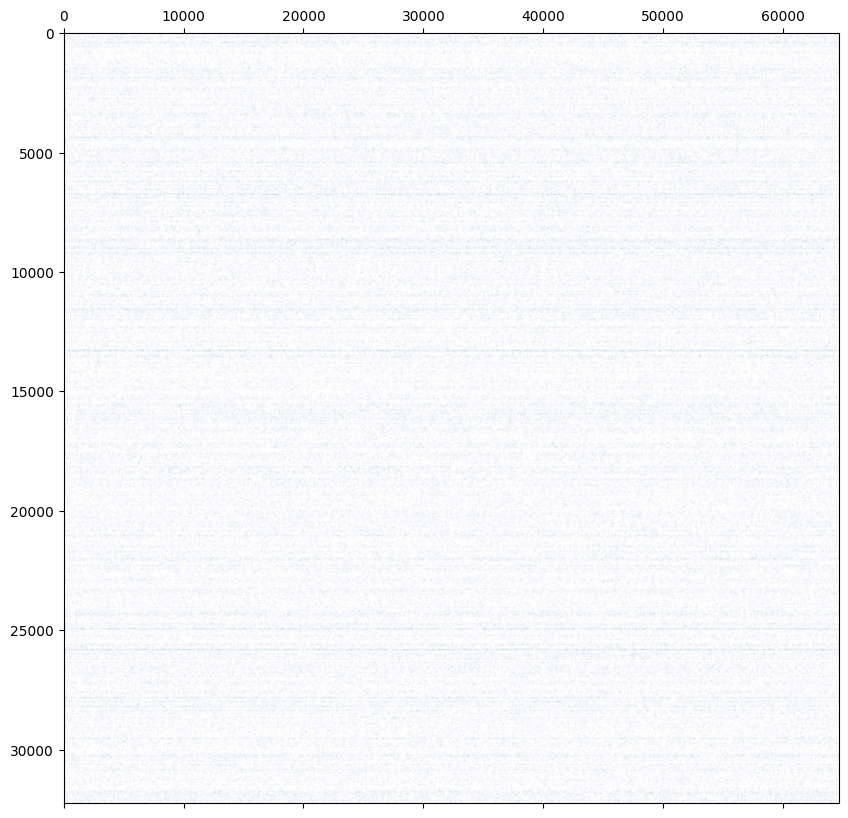

In [4]:

#zero pad x dimension by longest sentence
encoded_docs = list(zip(*zip_longest(*docs.to_list(), fillvalue=0)))

#convert to sparse matrix
encoded_docs = csr_array(encoded_docs, dtype=int)

#convert to index for each word
row_column_code = find(encoded_docs)

#presort by words
word_sorted_index = row_column_code[2].argsort()
doc_word = np.array([row_column_code[0][word_sorted_index], row_column_code[2][word_sorted_index]])

#presort by docs and words
doc_word_sorted_index = doc_word[0].argsort()
doc_word = pd.DataFrame(np.array([doc_word[0][doc_word_sorted_index], doc_word[1][doc_word_sorted_index]]).T, columns=['doc','word'])

#offset code no longer needed after zero-fill
doc_word.word = doc_word.word - 1

#convert to index of word counts per document
doc_word_count  = doc_word.groupby(['doc','word']).size().to_frame('count').reset_index().to_numpy().T

#convert to sparse matrix
sparse_word_doc_matrix = csr_array((doc_word_count[2],(doc_word_count[0],doc_word_count[1])), shape=(np.size(encoded_docs, 0),len(dictionary)), dtype=float).T

#visualize sparse matrix
fig = figure(figsize=(10,10))
sparse_word_doc_matrix_visualization = fig.add_subplot(1,1,1)
display(sparse_word_doc_matrix_visualization.spy(sparse_word_doc_matrix, markersize=0.007, aspect = 'auto'))

%store sparse_word_doc_matrix
%store dictionary
%store dictionary_lookup

The visualization below shows the words (y-axis) and the documents (x-axis) they are in. Across 600000 documents the terms in the corpus that re-occur more regularly form an interesting pattern of lines.

The words that occur together often in the corpus also, as word vectors, are closer together in this 600000 dimensional vector space. This is demonstrated in the table below.

In [5]:
#approximating cosine similarity with dot product of the term document matrix and its transform

similarity_matrix  = sparse_word_doc_matrix @ sparse_word_doc_matrix.T

#displaying slice of matrix with highest similarity scores

similarity_matrix_compressed = similarity_matrix[(-similarity_matrix.sum(axis = 1)).argsort()[:6]].toarray()

pd.DataFrame((-similarity_matrix_compressed).argsort(axis = 1)[:6,:6].T).applymap(dictionary_lookup.get)

,0,1,2,3,4,5
0,police,new,man,says,court,nsw
1,man,zealand,charged,govt,man,govt
2,probe,police,police,minister,face,rural
3,investigate,laws,court,australia,told,country
4,missing,australia,murder,new,accused,hour
5,search,council,missing,labor,murder,police


The documents with the most similarities are closer together in the vector space.

In [6]:
#previewing document similarity

doc_similarity_matrix  = sparse_word_doc_matrix.T @ sparse_word_doc_matrix

#displaying slice of matrix with highest similarity scores

doc_similarity_matrix_compressed = doc_similarity_matrix[(-doc_similarity_matrix.sum(axis = 1)).argsort()[:6]].toarray()

pd.DataFrame((-doc_similarity_matrix_compressed).argsort(axis = 1)[:6,:6].T).applymap(df.headline_text.to_dict().get)

,0,1,2,3,4,5
0,new england police launch new crime fighting team,police allege nsw man stalked hobart woman for...,new police officers posted to new england,family in sydney police brawl say police used ...,woman dies in bangor house fire sydney nsw police,man arrested in nsw over death of missing man ...
1,new police officers posted to new england,hobart man spends five years making artwork fr...,new england police launch new crime fighting team,police investigate fatal police shooting of knife,fatal sydney house fire sparks police probe,man arrested over goroke death
2,social media new crime fighting tool for police,police question man over missing woman,papua new guinea gets new leader,police say presidential debate explosion cause...,woman dies from burns suffered in yamba house ...,man arrested over stabbing death
3,papua new guinea gets new leader,woman dies in bangor house fire sydney nsw police,new perjury threat to papua new guinea anti,png police vote to force australians out,third family member dies after sydney house fire,man arrested over stabbing death
4,new earthquake fault found in new zealands cap...,police to quiz man again over missing warwick ...,new earthquake fault found in new zealands cap...,jokers new years trouble free police say,elderly man dies in house fire,nsw man to face court over womans death
5,new perjury threat to papua new guinea anti,two nyc police officers assassinated by man who,new jets strip; new identity,search on for stolen car used to ram police,four year old dies in house fire,wanted man conan taylor arrested after alleged...


In [19]:


first_word = np.resize(sparse_word_doc_matrix[[0],:].toarray(),int(2**16))

np.sum(first_word**2)

1.0

In [28]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble, execute, Aer
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit.quantum_info import Statevector

In [ ]:
word_vec = QuantumRegister(16)
#centroid = QuantumRegister(16)
#swap_space = QuantumRegister(2)
creg = ClassicalRegister(1)

circuit = QuantumCircuit(word_vec, creg)

circuit.initialize(first_word,word_vec)

state = Statevector(circuit)

plot_state_qsphere(state)


